In [1]:
from nilearn import plotting, image
import nibabel as nib
import os
import numpy as np
from pathlib import Path
import tarfile
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sub_list = os.listdir("HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2")
make_path = lambda x: "HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2" + "/" + x

In [3]:
def data_uploader(file_path):
    return np.loadtxt(file_path)

In [4]:
paths_100 = [make_path(i) for i in sub_list]
sub_data = [np.loadtxt(path) for path in paths_100]

### One Subject

In [6]:
path = make_path(sub_list[0])
data = data_uploader(path)
X = np.array(data).astype(float)
X.shape #timepoints, brain regions

(4800, 100)

In [7]:
corr1 = np.corrcoef(X.T)
corr1.shape

(100, 100)

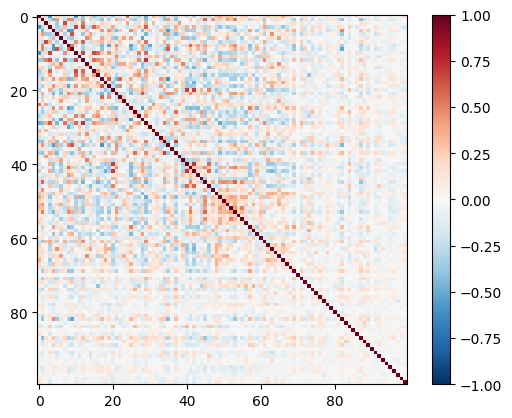

In [8]:
plt.imshow(corr1, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

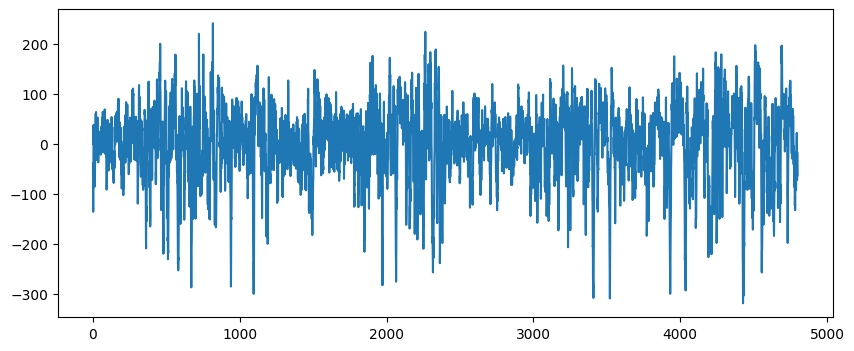

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(X.T[0])

In [10]:
np.std(X.T[0])

np.float64(74.47529661688012)

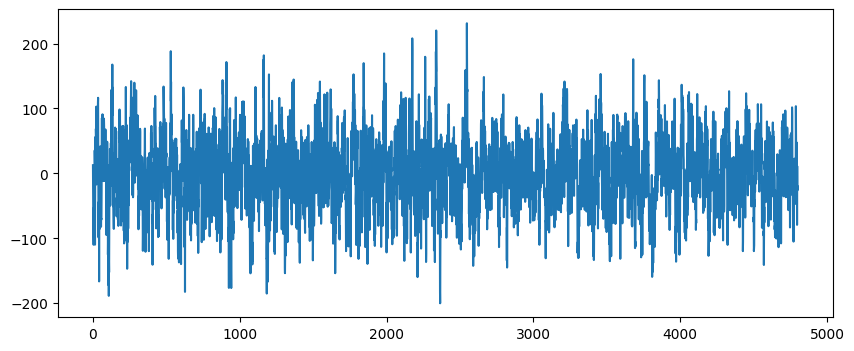

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(X.T[50])

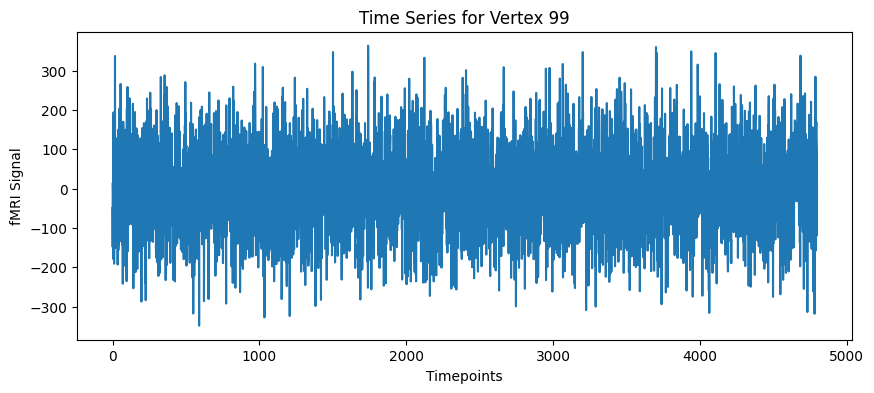

In [12]:
vertex_idx = 99
plt.figure(figsize=(10, 4))
plt.plot(X[0:, vertex_idx])
plt.title(f'Time Series for Vertex {vertex_idx}')
plt.xlabel('Timepoints')
plt.ylabel('fMRI Signal')
plt.show()

### Part 1: Try to average over multiple subjects

In [13]:
import nilearn.connectome as nc

In [14]:
sum(sub_data[1][:, 0])

np.float64(6.378021999998552)

In [15]:
sub_data[1].sum(axis=0)

array([ 6.378022  ,  0.48842   , -0.0140024 ,  1.903131  ,  0.798806  ,
        0.566513  ,  0.825554  ,  1.472018  , -5.518307  ,  0.5224174 ,
       -1.8758441 ,  1.3376301 , -0.466095  , -0.98502   , -4.282556  ,
       -1.886299  , -0.588089  ,  4.5858235 ,  1.34594208, -0.8541046 ,
        0.845162  , -1.00281   ,  0.1153546 , -1.0190523 ,  4.235223  ,
       10.9612159 , -0.6192982 ,  6.6068286 , -4.059312  , -0.406314  ,
        2.5386725 ,  1.43454   ,  3.13452   , -0.187211  , -1.092368  ,
       -1.228717  , -1.17849944, -3.284346  ,  2.517338  , -3.5654151 ,
        1.848404  , -2.624229  ,  1.516147  ,  0.765422  , -0.7892451 ,
        0.4831056 , -1.7621382 , -0.5358952 ,  0.530287  , -2.2177345 ,
       -3.873306  , -0.9315452 , -9.5900596 ,  0.249677  ,  1.12742   ,
       -0.9691555 , -0.2981493 ,  0.0155497 ,  1.0094118 ,  3.283138  ,
       -7.184701  ,  5.59637102,  3.562725  ,  1.4020335 ,  1.091671  ,
       -0.203821  , -2.6281391 , -1.356448  , -2.123287  ,  0.69

In [16]:
sub_data_var1 = np.array([sub/ sub.std(axis=0) for sub in sub_data]) #sub_data[1] / sub_data[1].std(axis=0)

In [17]:
cm = nc.GroupSparseCovariance()
cov_matrix = cm.fit(sub_data_var1)

In [18]:
#computes all covariances at once? Not sure how to combine these still
cm.covariances_

array([[[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
        [ 1.01242151e-01, -1.99760857e-02,  1.11627898e-01, ...,
          5.90889808e-02,  1.84015029e-02,  5.63665416e-02],
        [ 1.57604159e-01,  3.50295186e-01, -1.41874018e-02, ...,
          2.53483283e-01,  4.48233212e-01,  3.27206058e-01],
        ...,
        [-4.73657757e-02, -1.32283817e-02,  3.20991936e-02, ...,
         -2.53417752e-02, -2.56820577e-02, -5.29404942e-02],
        [ 8.91898529e-02, -4.31605437e-02,  1.23740920e-01, ...,
          1.01818934e-01,  2.43338375e-03,  2.43409626e-02],
        [ 1.30696097e-01,  1.95684355e-02,  3.19914873e-02, ...,
          6.84873873e-02, -3.67253444e-02,  3.12695641e-02]],

       [[ 1.01242151e-01, -1.99760857e-02,  1.11627898e-01, ...,
          5.90889808e-02,  1.84015029e-02,  5.63665416e-02],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          1.00000000e+00,  1.00000000e

In [19]:
#average each region signal across all subjects
X = sub_data_var1.mean(axis=0)
corr = np.corrcoef(X.T)

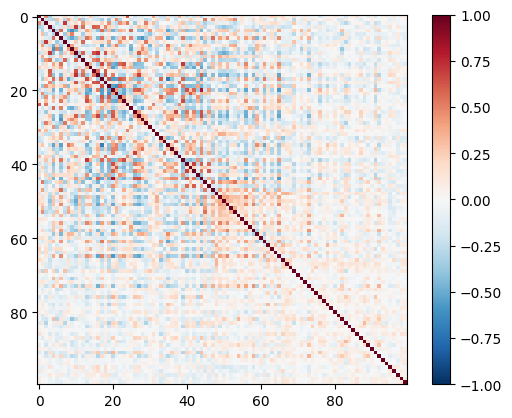

In [20]:
plt.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

### Averaging the covariance matrices

In [21]:
arr = cm.covariances_
arr.shape

(100, 100, 1003)

In [22]:
#averaging covariance matrices
combined_covariance = np.mean(cm.covariances_, axis=2)

In [23]:
combined_covariance.shape

(100, 100)

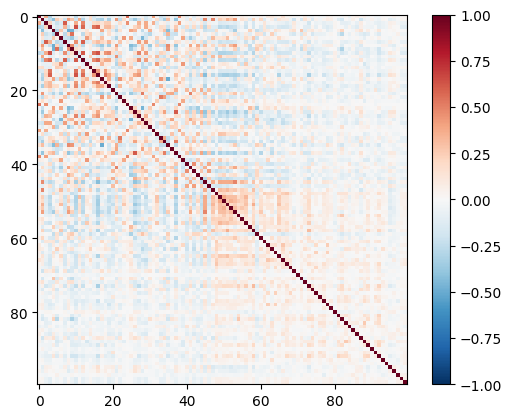

In [24]:
plt.imshow(combined_covariance, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

In [25]:
#Hierarchial Bayesian Model???

### Part 2: Try to map brain connectivity

atlas has shape ['x', 'y', 'z', 'region'] = (91, 109, 91, 100)


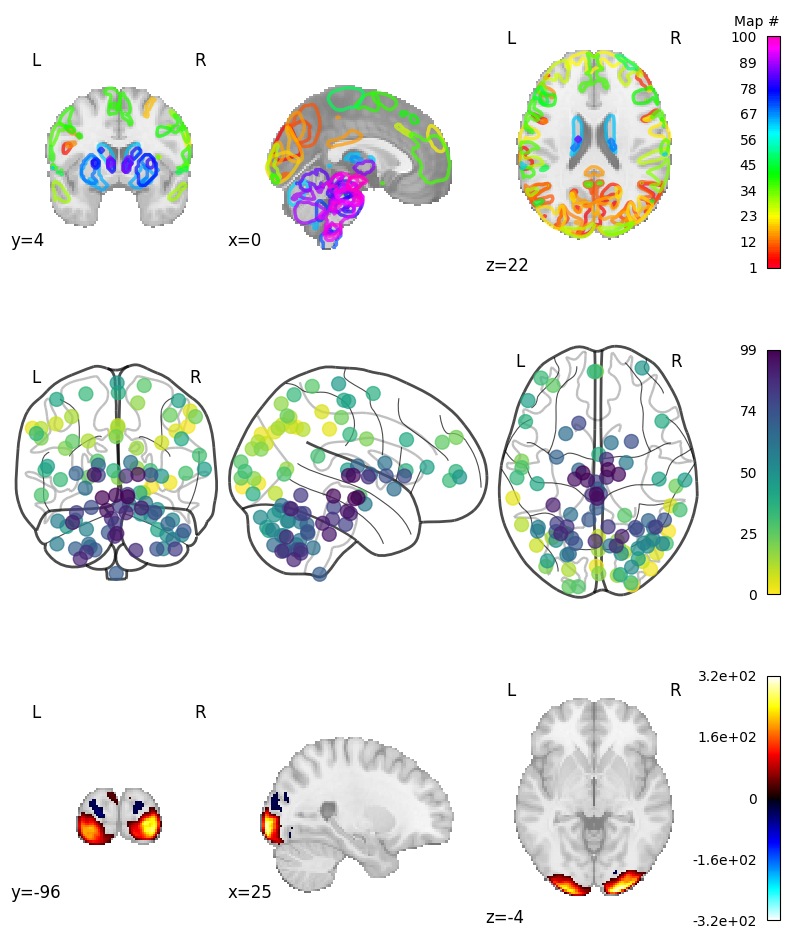

In [26]:
atlas = image.load_img("HCP_PTN1200/groupICA/groupICA_3T_HCP1200_MSMAll_d100.ica/melodic_IC_sum.nii.gz")
atlas = image.threshold_img(atlas, "99.5%") 
print("atlas has shape", ["x", "y", "z", "region"], "=", atlas.shape)

fig, axs = plt.subplots(nrows=3, figsize=(10, 12))

# plot atlas, all regions
plotting.plot_prob_atlas(atlas, colorbar=True, draw_cross=False, axes=axs[0])

# plot atlas, center coordinates
# get the x,y,z coordinates for each of the regions
atlas_coords = plotting.find_probabilistic_atlas_cut_coords(atlas)
plotting.plot_markers(node_values=np.arange(100), node_coords=atlas_coords, axes=axs[1])

# plot atlas, one region
idx = 0 # first region
atlas_region = image.index_img(atlas, idx)
plotting.plot_stat_map(
    atlas_region, draw_cross=False, axes=axs[2]
)

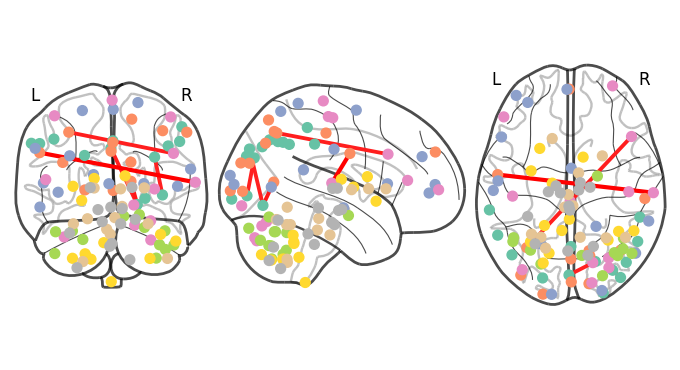

In [45]:
# plot it on the brain (averaging over all subjects)
plotting.plot_connectome(corr, atlas_coords, edge_threshold="99.9%")

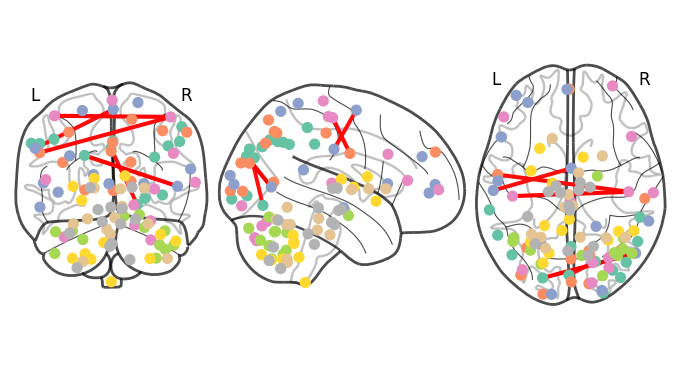

In [46]:
# plot it on the brain on one subject!!!
plotting.plot_connectome(corr1, atlas_coords, edge_threshold="99.9%")

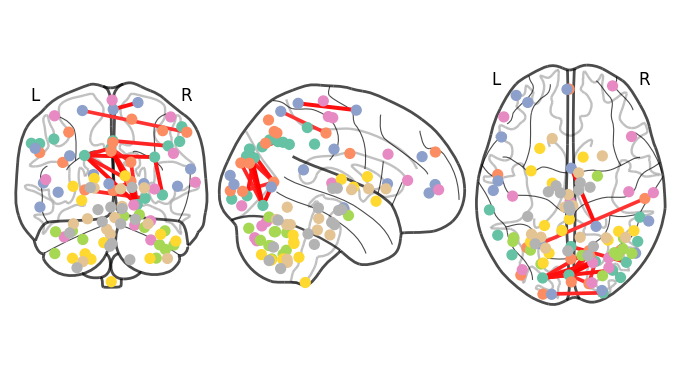

In [27]:
# If it is a string it must finish with a percent sign, e.g. “25.3%”, 
# and only the edges with a abs(value) above the given percentile will be shown.
plotting.plot_connectome(combined_covariance, atlas_coords, edge_threshold="99.7%")

In [89]:
#find the percentile regions
perc = np.percentile(abs(combined_covariance.flatten()), 98.7)

In [91]:
truth = combined_covariance >= perc
index = np.where(truth == True)
np.where(index[0] != index[1])

(array([ 1,  4,  6,  7,  8,  9, 12, 14, 16, 18, 20, 22, 23, 24, 26, 27, 28,
        30, 33, 34, 36, 37, 38, 40, 42, 48, 50, 54, 61, 66]),)

In [92]:
coord = [(index[0][i], index[1][i]) for i in np.where(index[0] != index[1])]
high_cor_pairings = np.stack(coord[0], axis=1)

In [93]:
unique_regions = list(set(high_cor_pairings.flatten()))
high_cor_coords = list(map(lambda x: x[1], filter(lambda x: x[0] in unique_regions, enumerate(atlas_coords))))

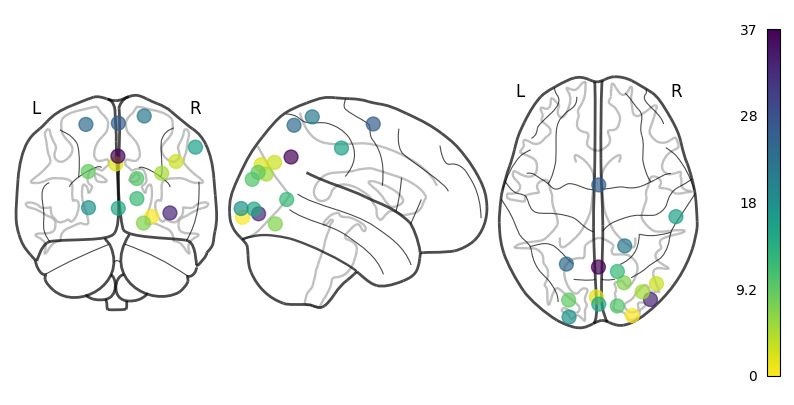

In [104]:
fig, axs = plt.subplots(nrows=1, figsize=(10, 5))
plotting.plot_markers(node_values=unique_regions, node_coords=high_cor_coords, axes=axs)

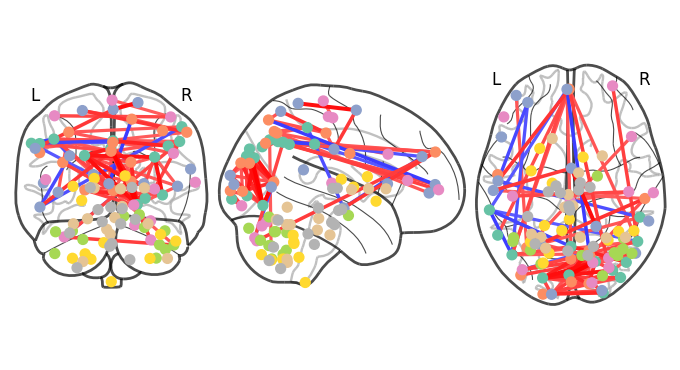

In [95]:
# If it is a string it must finish with a percent sign, e.g. “25.3%”, 
# and only the edges with a abs(value) above the given percentile will be shown.
plotting.plot_connectome(combined_covariance, atlas_coords, edge_threshold="98.7%")

In [ ]:
#it kind of looks like the edges don't match up... with my own percentile analysis... not sure why?

### Part 3: Try sliding window averaging covariance matrix

In [105]:
data.shape

(4800, 100)

In [110]:
len_5_min = 4800/4/3

In [199]:
def sliding_windows(data, num_windows):
    len_window = 4800//num_windows
    window_matrices = []
    fig, axs = plt.subplots(num_windows//4, 4, figsize=(15, 10))
    for i in range(num_windows):
        row = i//4
        col = i % 4
        i = int(i*len_window//2)
        lil_data = data[i: i + len_window]
        sub_corr_matrix = np.corrcoef(lil_data.T)
        window_matrices.append(sub_corr_matrix) 
        img = axs[row][col].imshow(sub_corr_matrix, cmap="RdBu_r",vmin=-1, vmax=1, interpolation="none")
        # axs[row][col].title(f"corr graph in window {i} to {i+len_5_min}")
        #plt.show()
    fig.colorbar(img, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, shrink = 0.4)
    return window_matrices

In [213]:
# Result Interpretation: A Jaccard Index close to 1 indicates high similarity, while a value closer to 0 indicates dissimilarity.
def jaccard_index(matrix1, matrix2, threshold=0.64):
    # Binarize matrices based on a threshold
    binary_matrix1 = (np.abs(matrix1) > threshold).astype(int)
    binary_matrix2 = (np.abs(matrix2) > threshold).astype(int)
    
    # Calculate intersection and union
    intersection = np.logical_and(binary_matrix1, binary_matrix2).sum()
    union = np.logical_or(binary_matrix1, binary_matrix2).sum()
    
    # Handle case where union is zero (avoid division by zero)
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    
    # Calculate Jaccard Index
    return intersection / union

def compute_scores(window_matrices, threshold=0.64):
    return {(i, i+1) :jaccard_index(window_matrices[i], window_matrices[i+1], threshold=threshold) for i in range(len(window_matrices)-1)}
# jaccard_score = jaccard_index(window_matrices[0], window_matrices[1], 0.64)
# print("Jaccard Index:", jaccard_score)

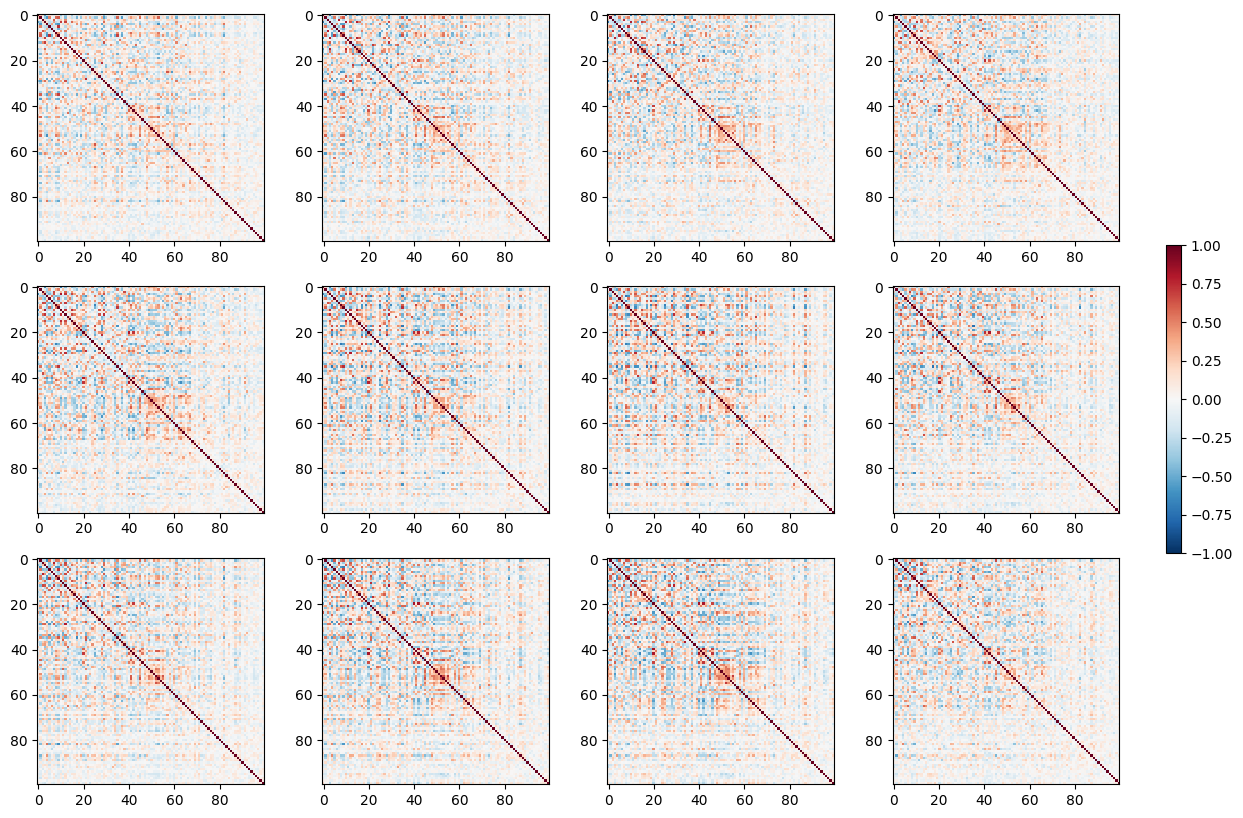

In [214]:
num_windows = 12
windows12 = sliding_windows(data, num_windows)

In [218]:
compute_scores(windows12)

{(0, 1): np.float64(0.7794117647058824),
 (1, 2): np.float64(0.9253731343283582),
 (2, 3): np.float64(0.782608695652174),
 (3, 4): np.float64(0.7808219178082192),
 (4, 5): np.float64(0.7325581395348837),
 (5, 6): np.float64(0.7340425531914894),
 (6, 7): np.float64(0.6703296703296703),
 (7, 8): np.float64(0.7162162162162162),
 (8, 9): np.float64(0.8055555555555556),
 (9, 10): np.float64(0.7848101265822784),
 (10, 11): np.float64(0.717948717948718)}

In [219]:
np.mean(list(compute_scores(windows12).values()))

np.float64(0.7663342265321312)

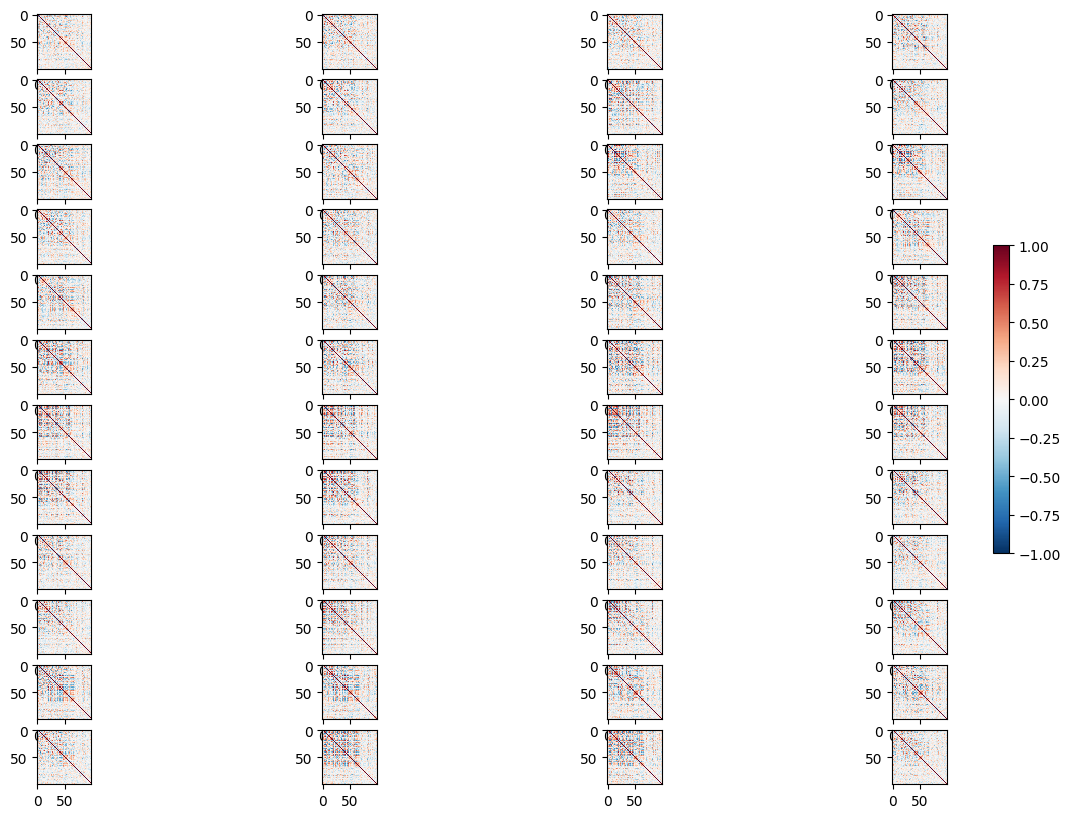

In [203]:
num_windows = 48
windows48 = sliding_windows(data, num_windows)

In [204]:
compute_scores(windows48)

[((0, 1), np.float64(0.7910447761194029)),
 ((1, 2), np.float64(0.726027397260274)),
 ((2, 3), np.float64(0.6547619047619048)),
 ((3, 4), np.float64(0.6421052631578947)),
 ((4, 5), np.float64(0.59)),
 ((5, 6), np.float64(0.6111111111111112)),
 ((6, 7), np.float64(0.5)),
 ((7, 8), np.float64(0.5619047619047619)),
 ((8, 9), np.float64(0.6601941747572816)),
 ((9, 10), np.float64(0.53125)),
 ((10, 11), np.float64(0.6066666666666667)),
 ((11, 12), np.float64(0.46258503401360546)),
 ((12, 13), np.float64(0.5979381443298969)),
 ((13, 14), np.float64(0.75)),
 ((14, 15), np.float64(0.7037037037037037)),
 ((15, 16), np.float64(0.7317073170731707)),
 ((16, 17), np.float64(0.6170212765957447)),
 ((17, 18), np.float64(0.5609756097560976)),
 ((18, 19), np.float64(0.4696969696969697)),
 ((19, 20), np.float64(0.4507042253521127)),
 ((20, 21), np.float64(0.5625)),
 ((21, 22), np.float64(0.5168539325842697)),
 ((22, 23), np.float64(0.4975124378109453)),
 ((23, 24), np.float64(0.44559585492227977)),
 ((2

In [220]:
np.mean(list(compute_scores(windows48).values()))

np.float64(0.5710870481004642)

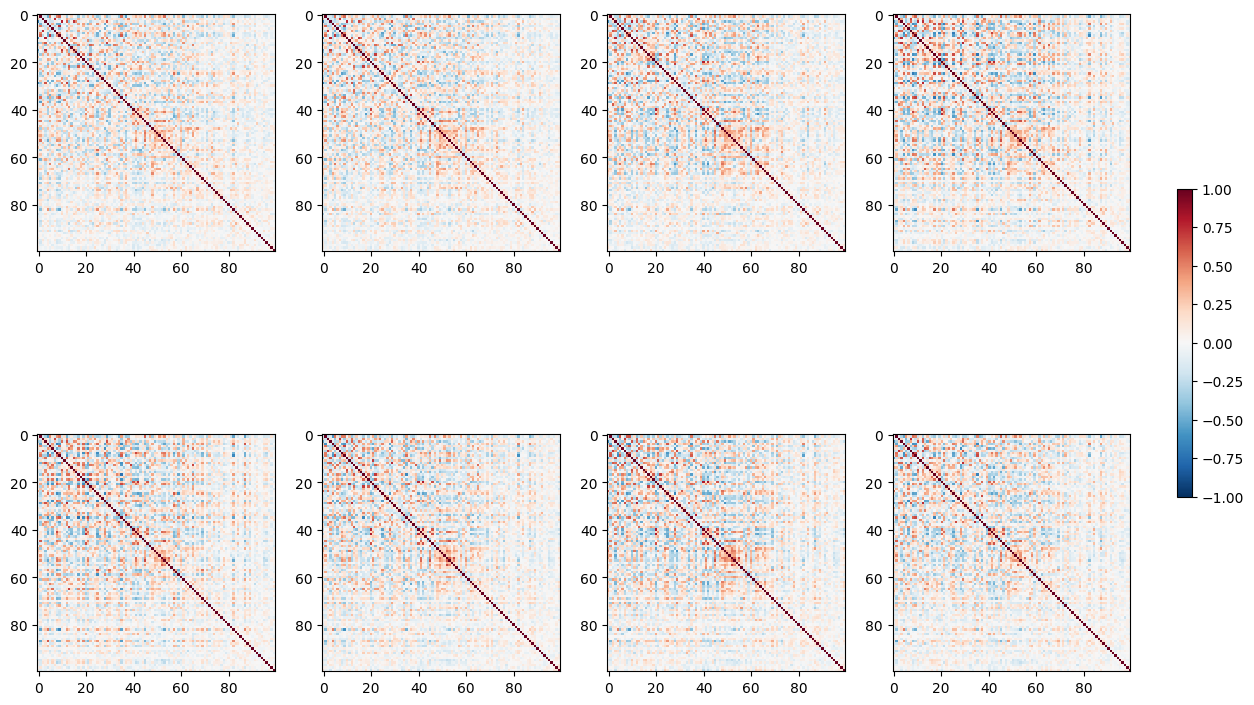

In [206]:
num_windows = 8
windows4 = sliding_windows(data, num_windows)

In [207]:
compute_scores(windows4)

[((0, 1), np.float64(0.9193548387096774)),
 ((1, 2), np.float64(0.8059701492537313)),
 ((2, 3), np.float64(0.7692307692307693)),
 ((3, 4), np.float64(0.7777777777777778)),
 ((4, 5), np.float64(0.7567567567567568)),
 ((5, 6), np.float64(0.8714285714285714)),
 ((6, 7), np.float64(0.7671232876712328))]

In [222]:
np.mean(list(compute_scores(windows4).values()))

np.float64(0.8096631644040738)

## Sliding Windows but make it regularized?

##### Applying Graphical LASSO on the whole data of one subject

In [9]:
#Computing windows but with graphical lasso:

import numpy as np
from sklearn.covariance import GraphicalLasso

# Generate synthetic data for demonstration
np.random.seed(42)
# n_samples, n_features = 100, 20
X = data

# Set the regularization parameter for L1 penalty (alpha)
alpha = 0.1  # Adjust this parameter for more or less sparsity

# Initialize and fit the GraphicalLasso model
model = GraphicalLasso(alpha=alpha, max_iter=10000, assume_centered=False)
model.fit(X)

# Retrieve the estimated precision matrix
precision_matrix = model.precision_

# Display the precision matrix
print("Estimated Precision Matrix:")
print(precision_matrix)

# Display the covariance matrix for completeness
covariance_matrix = model.covariance_
print("\nEstimated Covariance Matrix:")
print(covariance_matrix)


Estimated Precision Matrix:
[[ 6.15589928e-04  7.93375937e-05 -1.77123118e-04 ...  1.18850280e-05
   1.24010613e-06 -4.22063744e-06]
 [ 7.93375937e-05  1.24622842e-03 -2.52323751e-04 ...  2.40533879e-05
   4.18591668e-06  1.49632696e-06]
 [-1.77123118e-04 -2.52323751e-04  1.49041551e-03 ...  4.28011221e-06
  -3.29781668e-06  5.66240558e-07]
 ...
 [ 1.18850280e-05  2.40533879e-05  4.28011221e-06 ...  1.90809371e-04
  -1.51466609e-06 -1.05726289e-05]
 [ 1.24010613e-06  4.18591668e-06 -3.29781668e-06 ... -1.51466609e-06
   8.78216214e-05 -1.74235715e-07]
 [-4.22063744e-06  1.49632696e-06  5.66240558e-07 ... -1.05726289e-05
  -1.74235715e-07  9.52991484e-05]]

Estimated Covariance Matrix:
[[ 5.54656981e+03  4.68347738e+02  6.36555535e+02 ... -2.76964813e+02
   7.47744999e+02  1.06432473e+03]
 [ 4.68347738e+02  3.85660790e+03 -3.45171064e+02 ... -3.40187656e+02
   2.73757618e+02 -2.96681455e+01]
 [ 6.36555535e+02 -3.45171064e+02  2.94204282e+03 ... -2.43909138e+02
  -7.84827969e+01  1.00840

In [16]:
import numpy as np
from sklearn.covariance import GraphicalLasso
from sklearn.model_selection import KFold
from scipy.linalg import logm

# Function to calculate log-likelihood of a covariance matrix given precision matrix
def log_likelihood(X, precision_matrix):
    n = X.shape[0]
    log_det = np.linalg.slogdet(precision_matrix)[1]  # log determinant
    trace_term = np.trace(X @ precision_matrix)       # trace term
    return -0.5 * (n * log_det - trace_term)

# Cross-validation function to select best lambda for each subject
def cross_val_graphical_lasso(X, lambda_values, n_splits=5):
    best_lambda = None
    best_score = -np.inf
    
    # K-Fold cross-validation setup
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Iterate over candidate lambda values
    for alpha in lambda_values:
        cv_score = 0
        
        # For each fold, split into train and validation sets
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            
            # Fit GraphicalLasso on training set
            model = GraphicalLasso(alpha=alpha, max_iter=1000, tol=1e-2)
            model.fit(X_train)
            
            # Calculate empirical covariance matrix on validation set
            cov_val = np.cov(X_val, rowvar=False)
            
            # Compute log-likelihood for validation set
            score = log_likelihood(cov_val, model.precision_)
            cv_score += score
        
        # Average score over folds
        avg_score = cv_score / n_splits
        
        # Update best lambda if current alpha has a higher score
        if avg_score > best_score:
            best_score = avg_score
            best_lambda = alpha

    return best_lambda

# Example usage
X = data

# Range of lambda values to test
lambda_values = np.logspace(-5, 10)  # Adjust as necessary

# Find optimal lambda for subject
best_lambda = cross_val_graphical_lasso(X, lambda_values)
print("Optimal lambda:", best_lambda)

# Fit the final model with the optimal lambda
model = GraphicalLasso(alpha=best_lambda)
model.fit(X)
precision_matrix = model.precision_

print("Estimated Precision Matrix with Optimal Lambda:")
print(precision_matrix)


Optimal lambda: 7543.120063354608
Estimated Precision Matrix with Optimal Lambda:
[[ 1.80291610e-04 -0.00000000e+00 -0.00000000e+00 ...  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00  2.59295222e-04  0.00000000e+00 ...  0.00000000e+00
  -0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00  0.00000000e+00  3.39899879e-04 ...  0.00000000e+00
   0.00000000e+00 -0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.62103365e-04
  -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00  0.00000000e+00 ... -0.00000000e+00
   7.89343088e-05 -0.00000000e+00]
 [-0.00000000e+00  0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
  -0.00000000e+00  8.36221348e-05]]


In [13]:
def sliding_windows_LASSOed(data, num_windows):
    len_window = 4800//num_windows
    window_matrices = []
    fig, axs = plt.subplots(num_windows//4, 4, figsize=(15, 10))
    for i in range(num_windows):
        row = i//4
        col = i % 4
        i = int(i*len_window//2)
        lil_data = data[i: i + len_window]
        X = lil_data
        alpha = 5179.474679231213
        model = GraphicalLasso(alpha=alpha, max_iter=1000)
        model.fit(X)
        # Retrieve the estimated precision matrix
        precision_matrix = model.precision_
        window_matrices.append(precision_matrix) 
        if num_windows <= 4:
            img = axs[col].imshow(precision_matrix, cmap="RdBu_r", interpolation="none")
        else:
            img = axs[row][col].imshow(precision_matrix, cmap="RdBu_r", interpolation="none")
        # axs[row][col].title(f"corr graph in window {i} to {i+len_5_min}")
        #plt.show()
    fig.colorbar(img, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, shrink = 0.4)
    return window_matrices

[array([[ 1.77929760e-04, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00,  3.01230829e-04,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-0.00000000e+00,  0.00000000e+00,  2.92128484e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.48128445e-04, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -0.00000000e+00,  7.83193837e-05, -0.00000000e+00],
        [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00,  8.41815495e-05]]),
 array([[ 2.17000359e-04, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00,  2.90410343e-04,  0.00000000e+00, ...,
          0.00000000e+00, -0.00000000e

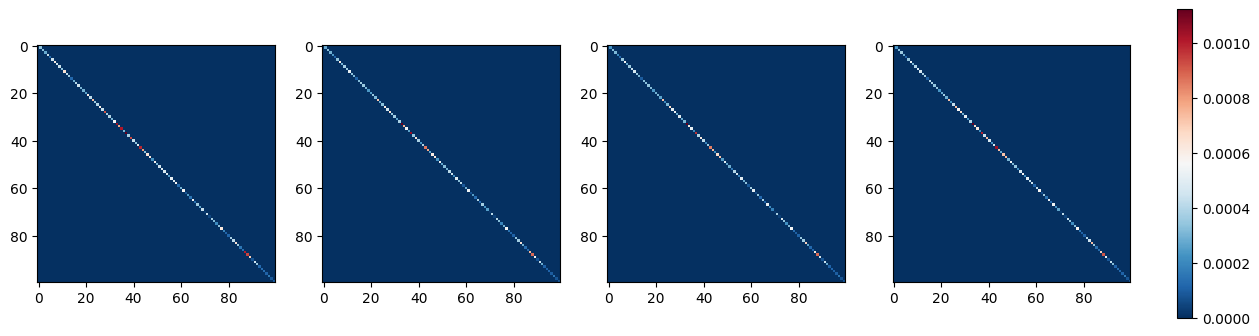

In [15]:
sliding_windows_LASSOed(data, 4)